<a href="https://colab.research.google.com/github/jjoy896/jjoy6__64061/blob/main/assignment_3/jjoy6_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, shutil, pathlib, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax

weather_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Weather")

#!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
#!unzip jena_climate_2009_2016.csv.zip

Read in file, Split into lines.

In [ ]:
fname = os.path.join(weather_dir/"jena_climate_2009_2016.csv")
#fname = os.path.join(weather_dir/"jena_climate_2009_2016_feature_e.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Finding the amount of observations to use in Data into Training, Validation, and Test sets

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

Preprocessing Data

In [ ]:
#Data Normalization
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Creation of timeseries datasets

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Testing output of data sets

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Common Sense Baseline

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Basic model using dense layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, 14))

#x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(inputs)
#x = layers.Flatten()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 133.6557 - mae: 9.4688 - val_loss: 69.8508 - val_mae: 6.8542
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 78.2031 - mae: 7.1653 - val_loss: 65.4952 - val_mae: 6.6588
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.2967 - mae: 7.0819 - val_loss: 65.5725 - val_mae: 6.6649
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.1697 - mae: 7.0768 - val_loss: 65.5150 - val_mae: 6.6624
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.0871 - mae: 7.0738 - val_loss: 65.1983 - val_mae: 6.6461
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.0623 - mae: 7.0728 - val_loss: 65.2014 - val_mae: 6.6462
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.1490 - mae: 7.0758 - val_loss: 65.4765 - val_mae: 6.6610
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.0663 - mae: 7.0733 - val_loss: 65.2403 - val_mae: 6.6489
Epoch 9/10
819/819 ━━━━━━━━━━━

ValueError: File not found: filepath=jena_dense.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model = keras.models.load_model("jena_dense05.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 65.6508 - mae: 6.6352
Test MAE: 6.64


Plotting Results of Dense Model

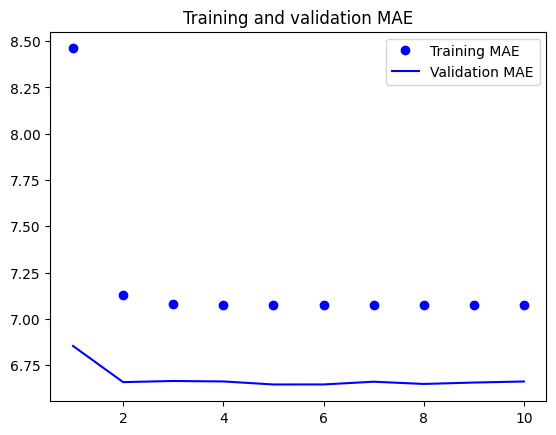

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Using convnets

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 34.8943 - mae: 4.4655 - val_loss: 16.6507 - val_mae: 3.2182
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 16.3744 - mae: 3.2222 - val_loss: 16.3466 - val_mae: 3.2312
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.9339 - mae: 3.0789 - val_loss: 16.2991 - val_mae: 3.2003
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.0642 - mae: 2.9839 - val_loss: 15.7298 - val_mae: 3.0987
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 13.3704 - mae: 2.9033 - val_loss: 13.8329 - val_mae: 2.9403
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.8879 - mae: 2.8507 - val_loss: 16.5348 - val_mae: 3.1584
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 12.3966 - mae: 2.7939 - val_loss: 16.3658 - val_mae: 3.1344
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.0350 - mae: 2.7545 - val_loss: 14.6007 - val_mae: 3.0120
Epoch 9/10
819/819 ━━━━━━━━━━━

In [ ]:
model = keras.models.load_model("jena_conv05.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 15.1478 - mae: 3.0930
Test MAE: 3.09


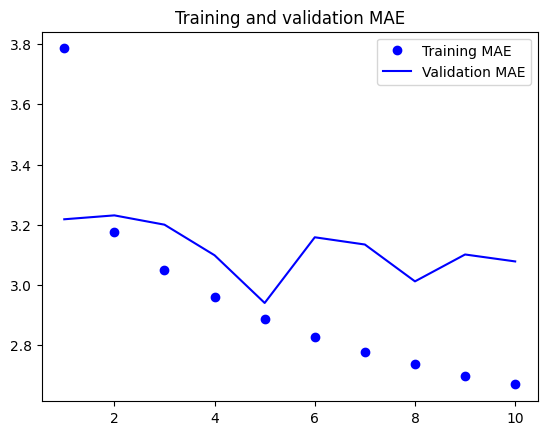

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM Model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 82.4568 - mae: 6.9921 - val_loss: 14.6086 - val_mae: 2.8825
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 12.6295 - mae: 2.7347 - val_loss: 9.5752 - val_mae: 2.4180
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.9530 - mae: 2.4592 - val_loss: 9.4844 - val_mae: 2.3868
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 9.3127 - mae: 2.3812 - val_loss: 9.3887 - val_mae: 2.3770
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 8.9188 - mae: 2.3297 - val_loss: 9.7684 - val_mae: 2.4194
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 8.5665 - mae: 2.2862 - val_loss: 9.8522 - val_mae: 2.4347
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.2867 - mae: 2.2436 - val_loss: 9.9045 - val_mae: 2.4521
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.0756 - mae: 2.2145 - val_loss: 9.8562 - val_mae: 2.4441
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

In [ ]:
model = keras.models.load_model("jena_lstm04.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.4773 - mae: 2.5560
Test MAE: 2.56


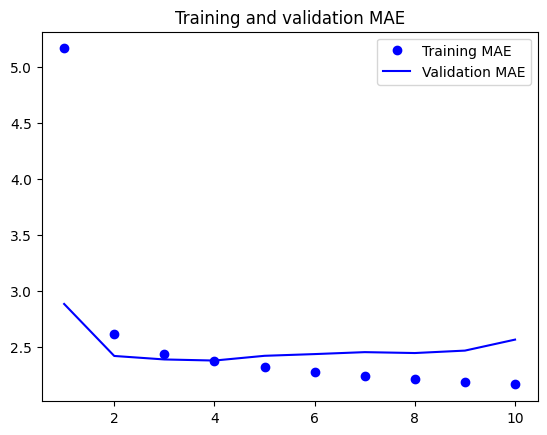

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("{epoch:02d}jena_simple_any{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 75.6049 - mae: 6.7537 - val_loss: 12.2738 - val_mae: 2.6268
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 11.7864 - mae: 2.6509 - val_loss: 9.2063 - val_mae: 2.3522
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.4906 - mae: 2.5215 - val_loss: 9.0446 - val_mae: 2.3359
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.3356 - mae: 2.5045 - val_loss: 8.9262 - val_mae: 2.3204
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.2407 - mae: 2.4911 - val_loss: 8.9124 - val_mae: 2.3175
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.1486 - mae: 2.4790 - val_loss: 8.9831 - val_mae: 2.3261
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.0526 - mae: 2.4682 - val_loss: 9.1174 - val_mae: 2.3391
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.9886 - mae: 2.4589 - val_loss: 8.9202 - val_mae: 2.3191
Epoch 9/20
819/819 ━━━━━━━━━━━━━

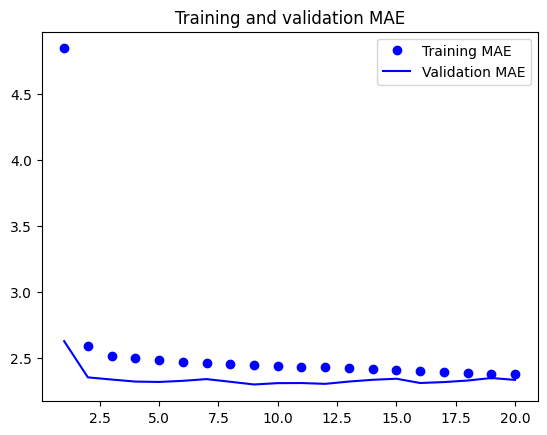

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("09jena_simple_any09.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.2191 - mae: 2.4925
Test MAE: 2.48


An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=False)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_simple_last{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 81.7869 - mae: 7.0944 - val_loss: 13.3217 - val_mae: 2.7230
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 12.2063 - mae: 2.6950 - val_loss: 9.1555 - val_mae: 2.3474
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.4600 - mae: 2.5219 - val_loss: 8.9448 - val_mae: 2.3230
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.2606 - mae: 2.4973 - val_loss: 9.0587 - val_mae: 2.3420
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.1359 - mae: 2.4797 - val_loss: 8.9678 - val_mae: 2.3306
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 10.0509 - mae: 2.4671 - val_loss: 9.1124 - val_mae: 2.3462
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.9983 - mae: 2.4601 - val_loss: 9.0599 - val_mae: 2.3429
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.9248 - mae: 2.4503 - val_loss: 9.0646 - val_mae: 2.3403
Epoch 9/20
819/819 ━━━━━━━━━━━━━━

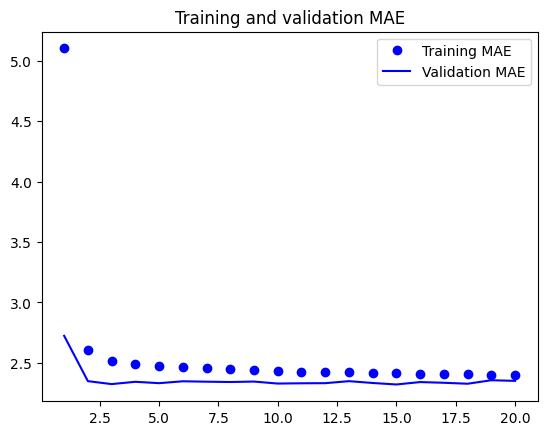

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_simple_last15.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.8055 - mae: 2.5380
Test MAE: 2.53


An RNN layer that returns its full output sequence

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_simple_full{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 99.7141 - mae: 8.0729 - val_loss: 65.4044 - val_mae: 6.6570
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 76.2770 - mae: 7.0702 - val_loss: 65.2590 - val_mae: 6.6502
Epoch 3/20
468/819 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 76.3415 - mae: 7.0712

KeyboardInterrupt: 

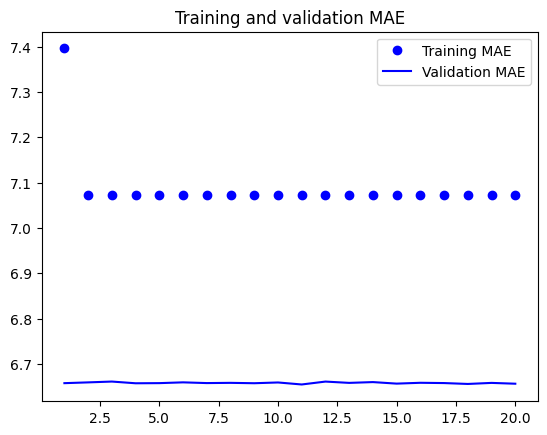

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_simple_full11.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 66.4820 - mae: 6.6622
Test MAE: 6.64


Stacking RNN layers

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
x = layers.SimpleRNN(16)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_simple_three{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 64.2698 - mae: 6.0530 - val_loss: 12.3714 - val_mae: 2.6587
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 11.8429 - mae: 2.6661 - val_loss: 9.5789 - val_mae: 2.4226
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 10.3693 - mae: 2.5138 - val_loss: 9.1881 - val_mae: 2.3718
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 10.0801 - mae: 2.4815 - val_loss: 8.9223 - val_mae: 2.3289
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 9.8499 - mae: 2.4494 - val_loss: 9.2231 - val_mae: 2.3697
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 9.7101 - mae: 2.4322 - val_loss: 9.0703 - val_mae: 2.3485
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 9.5545 - mae: 2.4126 - val_loss: 9.2409 - val_mae: 2.3871
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 9.4904 - mae: 2.4031 - val_loss: 9.1016 - val_mae: 2.3570
Epoch 9/20
819/819 ━━━━━━━━━━━━━━━━

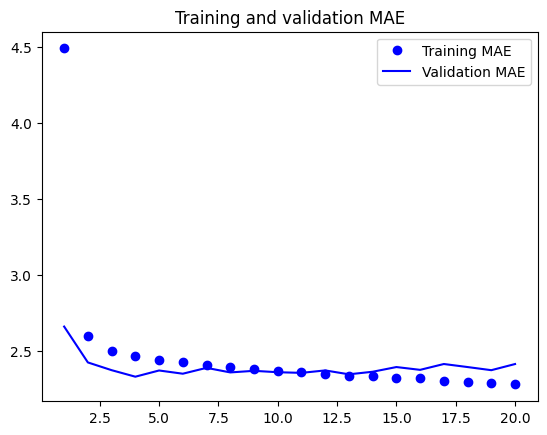

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_simple_three04.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 10.3563 - mae: 2.5090
Test MAE: 2.50


Using recurrent dropout to fight overfitting
Training and evaluating a dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(120, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 75ms/step - loss: 48.6683 - mae: 5.1404 - val_loss: 9.5235 - val_mae: 2.4033
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 15.3710 - mae: 3.0506 - val_loss: 9.1213 - val_mae: 2.3520
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 14.5729 - mae: 2.9647 - val_loss: 9.2979 - val_mae: 2.3730
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 14.0243 - mae: 2.9082 - val_loss: 8.9351 - val_mae: 2.3250
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 56s 69ms/step - loss: 13.6203 - mae: 2.8631 - val_loss: 9.0792 - val_mae: 2.3325
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step - loss: 13.1927 - mae: 2.8226 - val_loss: 9.1276 - val_mae: 2.3426
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 12.8704 - mae: 2.7839 - val_loss: 9.0351 - val_mae: 2.3328
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 12.6639 - mae: 2.7634 - val_loss: 9.0371 - val_mae: 2.3345
Epoch 9/50
819/819 ━━━━━━━━━━━━━

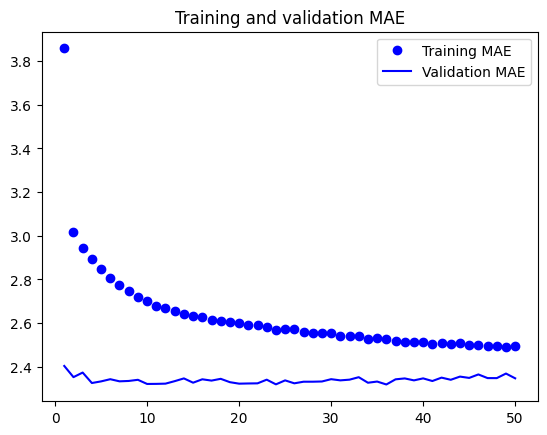

405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 10.0730 - mae: 2.5243
Test MAE: 2.52


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_lstm_dropout24.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("1jena_gru_dropout{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 84ms/step - loss: 73.1708 - mae: 6.5777 - val_loss: 14.5972 - val_mae: 2.8771
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - loss: 19.1280 - mae: 3.3878 - val_loss: 10.5380 - val_mae: 2.4964
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - loss: 16.2134 - mae: 3.1341 - val_loss: 9.5119 - val_mae: 2.3932
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step - loss: 15.1084 - mae: 3.0251 - val_loss: 9.1612 - val_mae: 2.3537
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - loss: 14.5702 - mae: 2.9677 - val_loss: 8.9651 - val_mae: 2.3309
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - loss: 14.1876 - mae: 2.9290 - val_loss: 8.8849 - val_mae: 2.3199
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - loss: 13.9895 - mae: 2.9062 - val_loss: 8.8524 - val_mae: 2.3145
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - loss: 13.7244 - mae: 2.8789 - val_loss: 8.7570 - val_mae: 2.3013
Epoch 9/20
819/819 ━━━━━━━━━━━

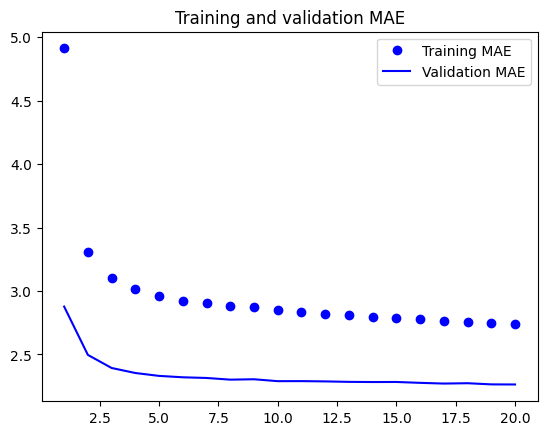

405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 9.8351 - mae: 2.4557
Test MAE: 2.45


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("1jena_gru_dropout20.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Bidirectional

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bi{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - loss: 51.9328 - mae: 5.2911 - val_loss: 10.9469 - val_mae: 2.5741
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 9.8582 - mae: 2.4584 - val_loss: 10.3003 - val_mae: 2.4906
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 8.7006 - mae: 2.3030 - val_loss: 9.9168 - val_mae: 2.4391
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 8.0954 - mae: 2.2234 - val_loss: 10.4332 - val_mae: 2.5169
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 7.6452 - mae: 2.1669 - val_loss: 10.5198 - val_mae: 2.5083
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 7.2841 - mae: 2.1164 - val_loss: 10.5923 - val_mae: 2.5076
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 6.9837 - mae: 2.0686 - val_loss: 10.8637 - val_mae: 2.5400
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 71ms/step - loss: 6.7627 - mae: 2.0352 - val_loss: 11.1203 - val_mae: 2.5710
Epoch 9/10
819/819 ━━━━━━━━━━━━━

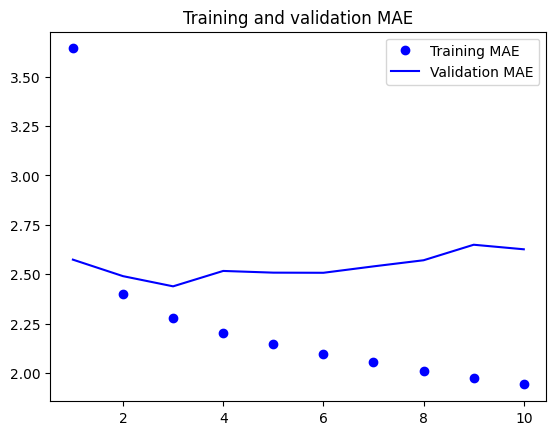

405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 10.4653 - mae: 2.5610
Test MAE: 2.56


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_bi03.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Trying adamax optimizer

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("3jena_adamax{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
#model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 125s 145ms/step - loss: 64.6097 - mae: 6.1178 - val_loss: 13.7538 - val_mae: 2.7639
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 113s 138ms/step - loss: 17.7559 - mae: 3.2399 - val_loss: 10.1491 - val_mae: 2.4408
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 115s 140ms/step - loss: 15.2552 - mae: 3.0292 - val_loss: 9.4016 - val_mae: 2.3726
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 114s 139ms/step - loss: 14.6926 - mae: 2.9738 - val_loss: 9.0993 - val_mae: 2.3393
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 14.2902 - mae: 2.9319 - val_loss: 8.9386 - val_mae: 2.3197
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 14.0006 - mae: 2.9021 - val_loss: 8.8752 - val_mae: 2.3105
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 13.7872 - mae: 2.8788 - val_loss: 8.8253 - val_mae: 2.3028
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 116s 141ms/step - loss: 13.6282 - mae: 2.8680 - val_loss: 8.7195 - val_mae: 2.2873
Epoch 9/10
819

Plot of Training and Validation MAE and Test results for Adamax

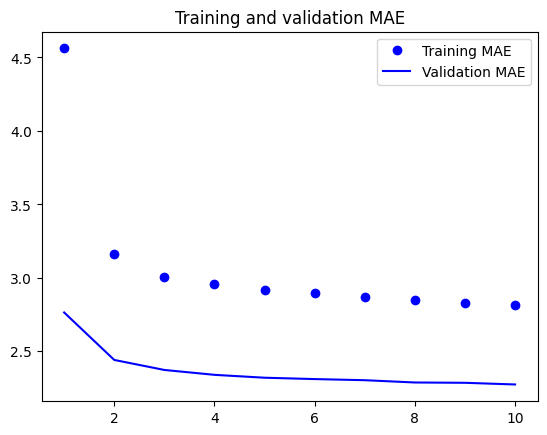

405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 9.7464 - mae: 2.4361
Test MAE: 2.44


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("3jena_adamax10.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Conv1D

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("4jena_conv{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 105ms/step - loss: 52.4990 - mae: 5.4172 - val_loss: 13.9200 - val_mae: 2.7901
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - loss: 17.3220 - mae: 3.1952 - val_loss: 10.1102 - val_mae: 2.4497
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - loss: 14.7230 - mae: 2.9717 - val_loss: 9.2645 - val_mae: 2.3639
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - loss: 14.0440 - mae: 2.9029 - val_loss: 9.0452 - val_mae: 2.3399
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - loss: 13.5538 - mae: 2.8602 - val_loss: 9.1015 - val_mae: 2.3476
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - loss: 13.1825 - mae: 2.8193 - val_loss: 8.9504 - val_mae: 2.3243
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 12.9081 - mae: 2.7888 - val_loss: 8.8022 - val_mae: 2.3120
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 12.6376 - mae: 2.7606 - val_loss: 8.7707 - val_mae: 2.3023
Epoch 9/10
819/819 ━━━

Plot of Training and Validation MAE and Test results Conv1D, two GRU layers, and dropout

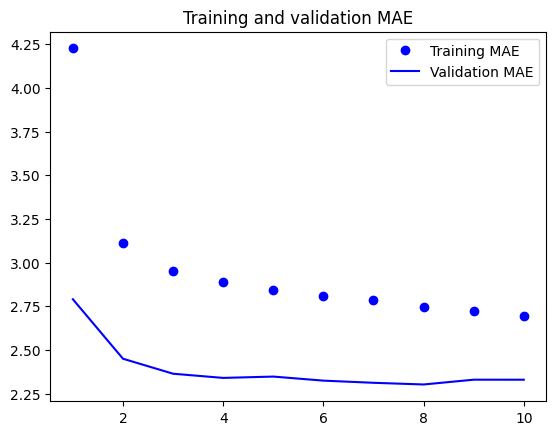

405/405 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 10.2644 - mae: 2.5098
Test MAE: 2.51


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("4jena_conv08.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Dense and GRU

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation = "linear")(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("5jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - loss: 46.5814 - mae: 5.0962 - val_loss: 9.6344 - val_mae: 2.4007
Epoch 2/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 113ms/step - loss: 15.0775 - mae: 3.0187 - val_loss: 9.0272 - val_mae: 2.3283
Epoch 3/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 114ms/step - loss: 13.7401 - mae: 2.8779 - val_loss: 8.8857 - val_mae: 2.3155
Epoch 4/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 12.8579 - mae: 2.7856 - val_loss: 8.9428 - val_mae: 2.3224
Epoch 5/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 114ms/step - loss: 12.1890 - mae: 2.7111 - val_loss: 8.9071 - val_mae: 2.3196
Epoch 6/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 114ms/step - loss: 11.7740 - mae: 2.6669 - val_loss: 8.8492 - val_mae: 2.3091
Epoch 7/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 114ms/step - loss: 11.3412 - mae: 2.6242 - val_loss: 8.8785 - val_mae: 2.3141
Epoch 8/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 112ms/step - loss: 11.0930 - mae: 2.5961 - val_loss: 8.7399 - val_mae: 2.2934
Epoch 9/30
819/819 ━━━━━

KeyboardInterrupt: 

Plot of Training and Validation MAE and Test results for Dense layer, 2 GRU layers, and adamax

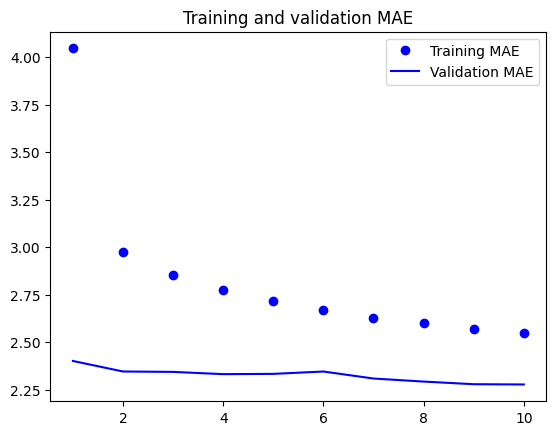

405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 9.4281 - mae: 2.3911
Test MAE: 2.39


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("5jena_dense10.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Conv1D, LSTM, Dense

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.Conv1D(8, 24, activation="relu")(x)
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation = "linear")(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 109ms/step - loss: 32.6755 - mae: 4.1857 - val_loss: 9.5148 - val_mae: 2.4178
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 90s 110ms/step - loss: 13.0811 - mae: 2.8198 - val_loss: 10.3605 - val_mae: 2.5056
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 87s 106ms/step - loss: 11.3444 - mae: 2.6310 - val_loss: 9.4993 - val_mae: 2.3925
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 105ms/step - loss: 10.4462 - mae: 2.5274 - val_loss: 9.8401 - val_mae: 2.4353
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - loss: 9.8233 - mae: 2.4577 - val_loss: 9.4142 - val_mae: 2.3877
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - loss: 9.3398 - mae: 2.3972 - val_loss: 9.7175 - val_mae: 2.4303
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 90s 109ms/step - loss: 8.9631 - mae: 2.3479 - val_loss: 9.9801 - val_mae: 2.4592
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 96s 118ms/step - loss: 8.5999 - mae: 2.2998 - val_loss: 10.7936 - val_mae: 2.5754
Epoch 9/10
819/819 ━━━━━━━

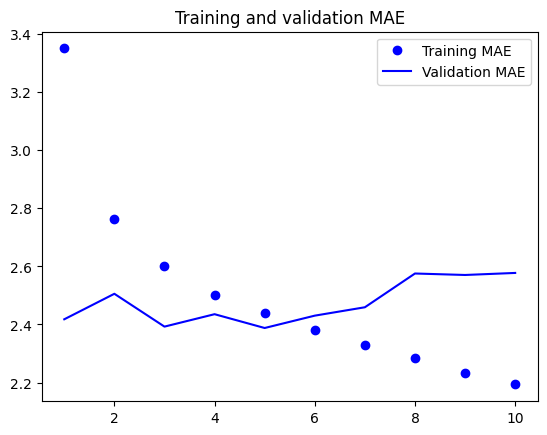

405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 10.7932 - mae: 2.6046
Test MAE: 2.61


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_conv05.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Extra layers and increased size selection

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(1)(x)

#outputs = layers.Dense(1, activation = "linear")(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_adamax_feature{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer="adamax", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 126s 146ms/step - loss: 45.4428 - mae: 4.9753 - val_loss: 9.5466 - val_mae: 2.3958
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 145ms/step - loss: 15.0083 - mae: 3.0091 - val_loss: 9.0687 - val_mae: 2.3404
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 14.0997 - mae: 2.9135 - val_loss: 8.8139 - val_mae: 2.3052
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 145ms/step - loss: 13.4057 - mae: 2.8428 - val_loss: 8.8078 - val_mae: 2.3040
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 146ms/step - loss: 12.8660 - mae: 2.7798 - val_loss: 8.7905 - val_mae: 2.3037
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 145ms/step - loss: 12.4260 - mae: 2.7404 - val_loss: 8.7446 - val_mae: 2.3006
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 12.2224 - mae: 2.7146 - val_loss: 8.6728 - val_mae: 2.2874
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 122s 149ms/step - loss: 12.1358 - mae: 2.7057 - val_loss: 8.6123 - val_mae: 2.2820
Epoch 9/10
819/8

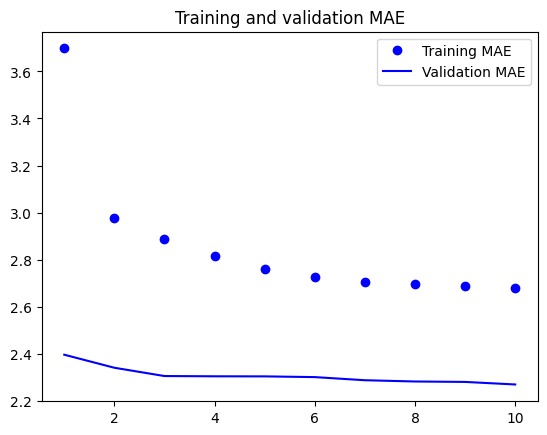

405/405 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 9.6146 - mae: 2.4212
Test MAE: 2.42


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_adamax_feature10.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("8jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("7jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 169ms/step - loss: 52.3501 - mae: 5.4393 - val_loss: 12.2093 - val_mae: 2.6158
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 169ms/step - loss: 16.6108 - mae: 3.1378 - val_loss: 9.5093 - val_mae: 2.3733
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 14.7755 - mae: 2.9661 - val_loss: 8.9226 - val_mae: 2.3089
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 166ms/step - loss: 14.1128 - mae: 2.9045 - val_loss: 8.7360 - val_mae: 2.2919
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 13.5941 - mae: 2.8486 - val_loss: 8.7082 - val_mae: 2.2926
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 13.3106 - mae: 2.8212 - val_loss: 8.6696 - val_mae: 2.2867
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 13.0070 - mae: 2.7929 - val_loss: 8.5181 - val_mae: 2.2630
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 12.7205 - mae: 2.7619 - val_loss: 8.6866 - val_mae: 2.2891
Epoch 9/10
819/

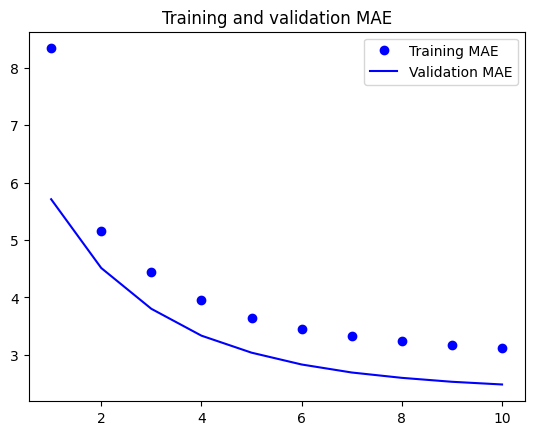

405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 14.5905 - mae: 2.8389
Test MAE: 2.84


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("8jena_dense08.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("8jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer=Adamax(learning_rate=0.0001), loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 94s 111ms/step - loss: 128.2434 - mae: 9.4543 - val_loss: 53.9245 - val_mae: 5.7112
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 112ms/step - loss: 49.3909 - mae: 5.3977 - val_loss: 35.8435 - val_mae: 4.5130
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - loss: 36.6824 - mae: 4.6024 - val_loss: 26.4003 - val_mae: 3.8024
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - loss: 28.8701 - mae: 4.0583 - val_loss: 20.5108 - val_mae: 3.3344
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - loss: 23.9818 - mae: 3.7125 - val_loss: 16.9082 - val_mae: 3.0382
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - loss: 21.1308 - mae: 3.5016 - val_loss: 14.5294 - val_mae: 2.8323
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 92s 112ms/step - loss: 19.1744 - mae: 3.3519 - val_loss: 12.9584 - val_mae: 2.6927
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 90s 110ms/step - loss: 17.9531 - mae: 3.2581 - val_loss: 11.9039 - val_mae: 2.5997
Epoch 9/10
819/

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("8jena_dense{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adamax", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(120, raw_data.shape[-1]))
x = layers.Conv1D(64, 24, activation="relu")(inputs)
x = layers.GRU(64, recurrent_dropout=0.2, return_sequences=True)(x)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout{epoch:02d}.keras",
                                    save_best_only=True)
]

model.compile(optimizer=Adamax(learning_rate=0.0001), loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 160s 187ms/step - loss: 90.1612 - mae: 7.5444 - val_loss: 45.0901 - val_mae: 5.0338
Epoch 2/50
802/819 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 41.1170 - mae: 4.7989

KeyboardInterrupt: 

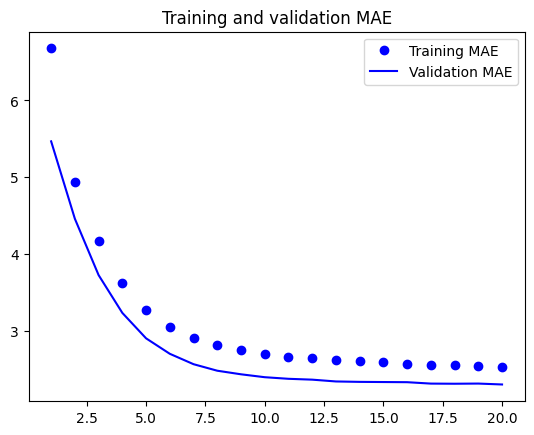

405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 10.1737 - mae: 2.4727
Test MAE: 2.48


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_lstm_dropout20.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_final{epoch:02d}.keras",
                                    save_best_only=True)
]
model.compile(optimizer=Adamax(learning_rate=0.0001), loss="mse", metrics=["mae"])
#model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 159ms/step - loss: 130.4037 - mae: 9.5190 - val_loss: 52.7653 - val_mae: 5.6122
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 131s 160ms/step - loss: 50.4506 - mae: 5.4651 - val_loss: 37.1002 - val_mae: 4.5984
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 127s 155ms/step - loss: 38.1847 - mae: 4.7037 - val_loss: 27.4264 - val_mae: 3.8832
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 124s 151ms/step - loss: 29.9503 - mae: 4.1406 - val_loss: 21.0253 - val_mae: 3.3787
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 121s 148ms/step - loss: 24.6449 - mae: 3.7635 - val_loss: 17.0874 - val_mae: 3.0565
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 146ms/step - loss: 21.4994 - mae: 3.5396 - val_loss: 14.6234 - val_mae: 2.8442
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 19.4688 - mae: 3.3811 - val_loss: 13.0930 - val_mae: 2.7098
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 118s 144ms/step - loss: 18.4109 - mae: 3.2976 - val_loss: 12.0716 - val_mae: 2.6195
Epoch 9

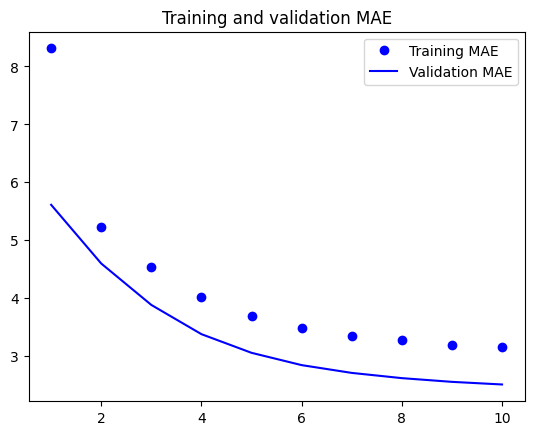

405/405 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - loss: 13.0087 - mae: 2.7127
Test MAE: 2.72


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_final10.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")